In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns

### Scrape the First Page of the Coffee Data

In [2]:
import requests
from bs4 import BeautifulSoup
source_code = requests.get('https://database.coffeeinstitute.org/coffees/arabica')
soup = BeautifulSoup(source_code.text, 'html5lib')

In [3]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import os
chromedriver = "/Applications/chromedriver" 
os.environ["webdriver.chrome.driver"] = chromedriver
driver = webdriver.Chrome(chromedriver)

### Grab the entire list of coffees from 1st page

In [459]:
driver.get('https://database.coffeeinstitute.org/coffees/arabica')
all_coffee=pd.DataFrame()

for page in range(1,28):
    soup = BeautifulSoup(driver.page_source, 'html5lib')
    time.sleep(3)
    
    one_list=soup.find('table', {'data-table':'coffees'})
    time.sleep(3)    
    
    one_list = pd.read_html(driver.page_source)
    time.sleep(3)
    
    one_list = pd.DataFrame(one_list[0])
    one_list.drop(['Unnamed: 0'], axis = 1, inplace = True)
    one_list['ID']=one_list['ID'].str.strip('#')
    all_coffee=pd.concat([all_coffee, one_list], axis=0)
    
    next_button = driver.find_element_by_xpath("//a[contains(text(), 'Next')]")
    next_button.click()

print(all_coffee.shape)
all_coffee.sort_values(by=["ID"], inplace=True)
all_coffee[:10]

(1350, 7)


,ID,Species,Country,Owner,Grade,ICP,Completed
34,100409,Arabica,Mexico,ALFREDO BOJALIL,79.67,amecafe,"June 4th, 2012"
30,10044,Arabica,Nicaragua,"Exportadora Atlantic, S.A.",80.17,acen,"April 24th, 2015"
26,102275,Arabica,"Tanzania, United Republic Of",DAE Ltd Company,81.67,afca,"January 2nd, 2015"
20,103581,Arabica,Mexico,CHRISTINA DUSING,81.67,amecafe,"July 27th, 2012"
49,103804,Arabica,Taiwan,CQI Taiwan ICP CQI台灣合作夥伴,80.42,bvi,"December 26th, 2013"
6,105651,Arabica,Mexico,MIGUEL CORTES MORENO,80.33,amecafe,"August 30th, 2012"
4,107500,Arabica,Brazil,Ipanema Coffees,83.08,bsca,"October 8th, 2015"
37,107587,Arabica,Mexico,OBED RENDON PONCE,79.58,amecafe,"September 17th, 2012"
0,108866,Arabica,Honduras,Elsy Reyes,82.50,ihcafe,"June 3rd, 2017"
23,10892,Arabica,Mexico,ORGANIZACIONES DE PRODUCTORES DE CAFE COLIMENSE,81.00,amecafe,"July 3rd, 2012"


In [501]:
# Resets the index
ind=range(len(all_coffee))
all_coffee['ind']=ind
all_coffee.set_index(['ind'], inplace=True)
all_coffee.sort_index(inplace=True)
all_coffee.head()

,ID,Species,Country,Owner,Grade,ICP,Completed
ind,,,,,,,
0,100409,Arabica,Mexico,ALFREDO BOJALIL,79.67,amecafe,"June 4th, 2012"
1,10044,Arabica,Nicaragua,"Exportadora Atlantic, S.A.",80.17,acen,"April 24th, 2015"
2,102275,Arabica,"Tanzania, United Republic Of",DAE Ltd Company,81.67,afca,"January 2nd, 2015"
3,103581,Arabica,Mexico,CHRISTINA DUSING,81.67,amecafe,"July 27th, 2012"
4,103804,Arabica,Taiwan,CQI Taiwan ICP CQI台灣合作夥伴,80.42,bvi,"December 26th, 2013"


__Pickle this data__

In [4]:
# os.chdir('/Users/bellepeng/Desktop/Metis/Work/Projects/')
!pwd

/Users/bellepeng/Desktop/Metis/Work/Projects/P2_coffee


In [502]:
with open('all_coffee.pkl', 'wb') as picklefile:
    pickle.dump(all_coffee, picklefile)

In [5]:
with open("all_coffee.pkl", 'rb') as picklefile: 
    all_coffee = pickle.load(picklefile)

all_coffee.head()

,ID,Species,Country,Owner,Grade,ICP,Completed
ind,,,,,,,
0,100409,Arabica,Mexico,ALFREDO BOJALIL,79.67,amecafe,"June 4th, 2012"
1,10044,Arabica,Nicaragua,"Exportadora Atlantic, S.A.",80.17,acen,"April 24th, 2015"
2,102275,Arabica,"Tanzania, United Republic Of",DAE Ltd Company,81.67,afca,"January 2nd, 2015"
3,103581,Arabica,Mexico,CHRISTINA DUSING,81.67,amecafe,"July 27th, 2012"
4,103804,Arabica,Taiwan,CQI Taiwan ICP CQI台灣合作夥伴,80.42,bvi,"December 26th, 2013"


### Grab the next level of pages by looping over the list of `all_coffee`

In [6]:
def get_one_coffee(i, one_coffee):
    # Table 1 - Total Score
    d = {'ID': [all_coffee['ID'][i]], 'Total_Score': [float(one_coffee[0][0][0])]}
    Total_Score = pd.DataFrame(data=d)
    Total_Score
    
    # Table 2 - Info
    info1=one_coffee[1][[0, 1]]
    info2=one_coffee[1][[2, 3]]
    info2.rename(columns={2:0, 3:1}, inplace=True)
    info0=pd.concat([info1, info2],  axis=0)
    info=info0.set_index(0).T
    info['ID']=all_coffee['ID'][i]

    # Table 3 - Cupping
    cupping1=one_coffee[2][[0, 1]]
    cupping2=one_coffee[2][[2, 3]]
    cupping2.rename(columns={2:0, 3:1}, inplace=True)
    cupping0=pd.concat([cupping1, cupping2],  axis=0)
    cupping0=cupping0.loc[cupping0[0] .isin(["Acidity", "Sweetness"])]
    cupping=cupping0.set_index(0).T
    cupping['ID']=all_coffee['ID'][i]
    
    # Table 4 - Green
    green1=one_coffee[3][[0, 1]]
    green2=one_coffee[3][[2, 3]]
    green2.rename(columns={2:0, 3:1}, inplace=True)
    green0=pd.concat([green1, green2],  axis=0).set_index(0)
    green0.drop([None], inplace=True)
    green=green0.T
    green['ID']=all_coffee['ID'][i]
    
    merge1=pd.merge(Total_Score, info, how="outer", on="ID")
    merge2=pd.merge(merge1, cupping, how="outer", on="ID")
    merge3=pd.merge(merge2, green, how="outer", on="ID")
    return merge3

In [21]:
len(all_coffee)
all_coffee[:5]

,ID,Species,Country,Owner,Grade,ICP,Completed
ind,,,,,,,
0,100409,Arabica,Mexico,ALFREDO BOJALIL,79.67,amecafe,"June 4th, 2012"
1,10044,Arabica,Nicaragua,"Exportadora Atlantic, S.A.",80.17,acen,"April 24th, 2015"
2,102275,Arabica,"Tanzania, United Republic Of",DAE Ltd Company,81.67,afca,"January 2nd, 2015"
3,103581,Arabica,Mexico,CHRISTINA DUSING,81.67,amecafe,"July 27th, 2012"
4,103804,Arabica,Taiwan,CQI Taiwan ICP CQI台灣合作夥伴,80.42,bvi,"December 26th, 2013"


In [26]:
# 331 the first time, reached 704 the second time, 973, 1261
# coffee_master=pd.DataFrame()

for i in range(1261, len(all_coffee)):
    # Get the soup for one coffee
    url='https://database.coffeeinstitute.org/coffee/'+all_coffee['ID'][i]
    driver.get(url)
    time.sleep(5)
    soup = BeautifulSoup(driver.page_source, 'html5lib')
    one_coffee=pd.read_html(driver.page_source)
    
    # parse the data
    coffee1=get_one_coffee(i, one_coffee)
    
    # Add to master dataframe
    coffee_master=pd.concat([coffee_master, coffee1], axis=0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [507]:
print(coffee_master.shape)
coffee_master.sort_values(by=["ID"], inplace=True)
coffee_master = coffee_master.reset_index()
coffee_master.drop(['index'], axis = 1, inplace = True)
# coffee_master[:10]

(1350, 27)


,ID,Total_Score,Country of Origin,Farm Name,Lot Number,Mill,ICO Number,Company,Altitude,Region,...,Variety,Status,Processing Method,Acidity,Sweetness,Moisture,Category One Defects,Quakers,Color,Category Two Defects
0,100409,79.67,Mexico,CONSOLAPA,NaN,NaN,1104363350,ECOMTRADING,1264,"COATEPEC, COATEPEC",...,Mundo Novo,Completed,Washed / Wet,7.17,10.00,0 %,0 full defects,0,NaN,9 full defects
1,10044,80.17,Nicaragua,Los Mesones,NaN,Planta procesadora Sebaco,017-053-0125,Exportadora Atlantic S.A,1100 - 1275 mts,Jinotega,...,Caturra,Completed,Washed / Wet,7.33,10.00,11 %,0 full defects,0,NaN,2 full defects
2,102275,81.67,"Tanzania, United Republic Of",Multiple,NaN,DAE Ltd,C001,DAE Ltd Company,1200-1800M,Mbinga,...,Other,Completed,Washed / Wet,7.42,10.00,12 %,0 full defects,0,Green,0 full defects
3,103581,81.67,Mexico,UCIPA SANTA CATARINA,NaN,ECC BENEFICIO VERACRUZ,1506803385,NaN,1200,VERACRUZ,...,Bourbon,Completed,Washed / Wet,7.42,10.00,11 %,0 full defects,0,Green,2 full defects
4,103804,80.42,Taiwan,Guoxing Farm Coffee 國姓農場咖啡,NaN,Guoxing Farm Coffee 國姓農場咖啡,NaN,Blossom Valley宸嶧國際,600 M,Nantou Guoxing 南投縣國姓鄉,...,Typica,Completed,Washed / Wet,7.25,10.00,11 %,0 full defects,0,Green,0 full defects
5,105651,80.33,Mexico,NaN,NaN,"COMUNIDAD DE SACÚN PALMA, MUNICIPIO DE CHILÓN,...",01-04,ESTRATEGIAS CONSTRUCTIVAS CORZU S.A. DE C.V.,940,CHILÓN,...,Typica,Completed,Semi-washed / Semi-pulped,7.33,10.00,11 %,0 full defects,0,Green,21 full defects
6,107500,83.08,Brazil,Rio Verde,NaN,Ipanema Comercial e Exportadora SA,002/4177/0164,Ipanema Coffees,1.000,South of Minas Gerais,...,Yellow Bourbon,Completed,Natural / Dry,7.33,10.00,0 %,0 full defects,0,Green,3 full defects
7,107587,79.58,Mexico,TEPETZINGO,NaN,MONTE BLANCO,1104379888,CAFETERA EL GRANDE S.A. DE C.V.,1250,TEPETZINGO,...,Typica,Completed,Washed / Wet,7.33,10.00,12 %,0 full defects,0,None,11 full defects
8,108866,82.50,Honduras,Las Cuchillas,165,CIGRAH S.A DE C.V,13-111-097,CIGRAH,1400,Comayagua,...,Caturra,Completed,Washed / Wet,7.50,10.00,10 %,0 full defects,0,Green,4 full defects
9,10892,81.00,Mexico,NaN,NaN,ORGANIZACION UNION DE EJIDOS ADOLFO LOPEZ MATEOS,2671,ORGANIZACIONES DE PRODUCTORES DE CAFE COLIMENS...,1100,ADOLFO LOPEZ MATEOS,...,Typica,Completed,Washed / Wet,7.67,10.00,0 %,0 full defects,0,Green,8 full defects


In [508]:
with open('coffee_master.pkl', 'wb') as picklefile:
    pickle.dump(coffee_master, picklefile)

In [560]:
with open("coffee_master.pkl", 'rb') as picklefile: 
    coffee_orig = pickle.load(picklefile)

In [4]:
with open("coffee_master.pkl", 'rb') as picklefile: 
    coffee_master = pickle.load(picklefile)
print(coffee_master.shape)
coffee_master.head()

(1350, 27)


,ID,Total_Score,Country of Origin,Farm Name,Lot Number,Mill,ICO Number,Company,Altitude,Region,...,Variety,Status,Processing Method,Acidity,Sweetness,Moisture,Category One Defects,Quakers,Color,Category Two Defects
0,100409,79.67,Mexico,CONSOLAPA,NaN,NaN,1104363350,ECOMTRADING,1264,"COATEPEC, COATEPEC",...,Mundo Novo,Completed,Washed / Wet,7.17,10.00,0 %,0 full defects,0,NaN,9 full defects
1,10044,80.17,Nicaragua,Los Mesones,NaN,Planta procesadora Sebaco,017-053-0125,Exportadora Atlantic S.A,1100 - 1275 mts,Jinotega,...,Caturra,Completed,Washed / Wet,7.33,10.00,11 %,0 full defects,0,NaN,2 full defects
2,102275,81.67,"Tanzania, United Republic Of",Multiple,NaN,DAE Ltd,C001,DAE Ltd Company,1200-1800M,Mbinga,...,Other,Completed,Washed / Wet,7.42,10.00,12 %,0 full defects,0,Green,0 full defects
3,103581,81.67,Mexico,UCIPA SANTA CATARINA,NaN,ECC BENEFICIO VERACRUZ,1506803385,NaN,1200,VERACRUZ,...,Bourbon,Completed,Washed / Wet,7.42,10.00,11 %,0 full defects,0,Green,2 full defects
4,103804,80.42,Taiwan,Guoxing Farm Coffee 國姓農場咖啡,NaN,Guoxing Farm Coffee 國姓農場咖啡,NaN,Blossom Valley宸嶧國際,600 M,Nantou Guoxing 南投縣國姓鄉,...,Typica,Completed,Washed / Wet,7.25,10.00,11 %,0 full defects,0,Green,0 full defects


### Test and Clean the data
* Not planning to model with ID, Farm, Mill, Company, Region, Producer, In country partner, Owner
* Need to parse 'Harvest_year'
* No issues with country, Processing_method
* Grouped: Quakers, Color
* Finished processing: Total Score, Altitude, Number_of_bags, Bag_weight, Acidity, Sweetness, Moisture, Defects_cat1, Quakers, Color, Defects_cat2, Grading_date, Total_weight, Variety, Quakers, Color

In [5]:
def find_strings(var):
    string_possibles=[re.search('[a-zA-Z]+', str(i)) for i in var]
    string_possibles2=[]
    for i in range(len(string_possibles)):
        if string_possibles[i]!=None:
            string_possibles2.append(string_possibles[i][0])
    len(string_possibles2) #604
    return(print(len(string_possibles2)), string_possibles2)

In [6]:
coffee_master.info()
coffee_master.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 27 columns):
ID                      1350 non-null object
Total_Score             1350 non-null float64
Country of Origin       1349 non-null object
Farm Name               999 non-null object
Lot Number              339 non-null object
Mill                    1048 non-null object
ICO Number              1199 non-null object
Company                 1147 non-null object
Altitude                1133 non-null object
Region                  1292 non-null object
Producer                1125 non-null object
Number of Bags          1350 non-null object
Bag Weight              1350 non-null object
In-Country Partner      1350 non-null object
Harvest Year            1297 non-null object
Grading Date            1350 non-null object
Owner                   1343 non-null object
Variety                 1149 non-null object
Status                  1350 non-null object
Processing Method       1200 non-null o

,Total_Score
count,1350.000000
mean,82.440881
std,2.081580
min,75.580000
25%,81.330000
50%,82.580000
75%,83.670000
max,90.580000


In [7]:
coffee_master.rename(columns={'Country of Origin': 'Country',
     'Farm Name': 'Farm',
     'Number of Bags': 'Number_of_bags',
     'Bag Weight': 'Bag_weight',
     'In-Country Partner': 'In_country_partner',
     'Harvest Year':'Harvest_year',
     'Grading Date':'Grading_date',
     'Processing Method': 'Processing_method',
     'Category One Defects': 'Defects_cat1',
     'Category Two Defects': 'Defects_cat2'                
    }, inplace=True)
list(coffee_master.columns)

['ID',
 'Total_Score',
 'Country',
 'Farm',
 'Lot Number',
 'Mill',
 'ICO Number',
 'Company',
 'Altitude',
 'Region',
 'Producer',
 'Number_of_bags',
 'Bag_weight',
 'In_country_partner',
 'Harvest_year',
 'Grading_date',
 'Owner',
 'Variety',
 'Status',
 'Processing_method',
 'Acidity',
 'Sweetness',
 'Moisture',
 'Defects_cat1',
 'Quakers',
 'Color',
 'Defects_cat2']

In [8]:
# Drop: Lot number , Status (all Completed) 
coffee_master.drop(['Lot Number', 'Status', 'ICO Number'], axis = 1, inplace = True)
coffee_master.head()

,ID,Total_Score,Country,Farm,Mill,Company,Altitude,Region,Producer,Number_of_bags,...,Owner,Variety,Processing_method,Acidity,Sweetness,Moisture,Defects_cat1,Quakers,Color,Defects_cat2
0,100409,79.67,Mexico,CONSOLAPA,NaN,ECOMTRADING,1264,"COATEPEC, COATEPEC",CECILIA AVILA CAMBEROS,253,...,ALFREDO BOJALIL,Mundo Novo,Washed / Wet,7.17,10.00,0 %,0 full defects,0,NaN,9 full defects
1,10044,80.17,Nicaragua,Los Mesones,Planta procesadora Sebaco,Exportadora Atlantic S.A,1100 - 1275 mts,Jinotega,Sheldom La rue,275,...,"Exportadora Atlantic, S.A.",Caturra,Washed / Wet,7.33,10.00,11 %,0 full defects,0,NaN,2 full defects
2,102275,81.67,"Tanzania, United Republic Of",Multiple,DAE Ltd,DAE Ltd Company,1200-1800M,Mbinga,DAE Ltd,20,...,DAE Ltd Company,Other,Washed / Wet,7.42,10.00,12 %,0 full defects,0,Green,0 full defects
3,103581,81.67,Mexico,UCIPA SANTA CATARINA,ECC BENEFICIO VERACRUZ,NaN,1200,VERACRUZ,CESAR SANTIZ LOPEZ,275,...,CHRISTINA DUSING,Bourbon,Washed / Wet,7.42,10.00,11 %,0 full defects,0,Green,2 full defects
4,103804,80.42,Taiwan,Guoxing Farm Coffee 國姓農場咖啡,Guoxing Farm Coffee 國姓農場咖啡,Blossom Valley宸嶧國際,600 M,Nantou Guoxing 南投縣國姓鄉,Huang san lang 黃三郎,10,...,CQI Taiwan ICP CQI台灣合作夥伴,Typica,Washed / Wet,7.25,10.00,11 %,0 full defects,0,Green,0 full defects


In [9]:
coffee_master['Sweetness']=[float(a) for a in coffee_master['Sweetness']]
coffee_master['Sweetness'].mean()

9.9381629629629629

In [10]:
coffee_master['Acidity']=[float(a) for a in coffee_master['Acidity']]
coffee_master['Acidity'].mean()

7.5513407407407405

In [11]:
coffee_master['Quakers']=[int(a) for a in coffee_master['Quakers']]
coffee_master['Quakers'].mean()

0.22962962962962963

In [12]:
coffee_master['Moisture']=[(float(a.strip('% '))/100) for a in coffee_master['Moisture']]
coffee_master['Moisture'].mean()

0.088925925925925922

In [13]:
def grab_defects(var):
    varlist=list(var)
    return [ int(c[:c.find('full')].strip()) for c in varlist ]
coffee_master['Defects_cat1']=grab_defects(coffee_master['Defects_cat1'])
coffee_master['Defects_cat2']=grab_defects(coffee_master['Defects_cat2'])

In [14]:
coffee_master['Number_of_bags'] = [int(a) for a in coffee_master['Number_of_bags']]
coffee_master['Number_of_bags'].mean()

154.09481481481481

In [15]:
find_strings(coffee_master['Bag_weight'])[1]
def convert_to_kg(s):
    s = s.lower().split()
    if len(s)==1:
        return float(s[0])
    elif s[1]=='lbs':
        return float(s[0])*0.453592
    else:
        return float(s[0])
coffee_master['Bag_weight_fixed']=[convert_to_kg(s) for s in coffee_master['Bag_weight']]
# coffee_master['Bag_weight_fixed'].describe()

1323


In [16]:
coffee_master['Grading_date']=pd.to_datetime(coffee_master['Grading_date']) 
coffee_master['Grading_year']=[x.year for x in coffee_master['Grading_date']]
coffee_master['Grading_year'].value_counts()  

2012    296
2014    237
2015    193
2013    151
2017    137
2016    123
2011     82
2018     81
2010     50
Name: Grading_year, dtype: int64

__Fixing the Altitude field__

In [17]:
# - take the first value (can consider taking the average in the future)
# M = meters do nothing
# <10, *1000
# "nan, NaN, n/a mmm" = None
#  FEET, ft, 
# 5,500-6,000 PSNM
# 公尺
# ,SNN

In [18]:
# Taiwan, China
coffee_master['Country'].value_counts()
coffee_master[coffee_master['Country']=='Taiwan']

,ID,Total_Score,Country,Farm,Mill,Company,Altitude,Region,Producer,Number_of_bags,...,Processing_method,Acidity,Sweetness,Moisture,Defects_cat1,Quakers,Color,Defects_cat2,Bag_weight_fixed,Grading_year
4,103804,80.42,Taiwan,Guoxing Farm Coffee 國姓農場咖啡,Guoxing Farm Coffee 國姓農場咖啡,Blossom Valley宸嶧國際,600 M,Nantou Guoxing 南投縣國姓鄉,Huang san lang 黃三郎,10,...,Washed / Wet,7.25,10.00,0.11,0,0,Green,0,30.0,2013
36,122914,80.08,Taiwan,Wu kun shan Coffee 吳焜山咖啡園,Wu kun shan Coffee 吳焜山咖啡園,Blossom Valley宸嶧國際,250 M,Changhua BaGuaShan 彰化市八卦山,Wu kun shan 吳焜山,10,...,Semi-washed / Semi-pulped,7.08,10.00,0.11,0,0,Green,0,30.0,2013
52,135265,81.50,Taiwan,Xu yuan zhang 徐源漳,Xu yuan zhang 徐源漳,Blossom Valley宸嶧國際,600 M,Taichung Xinshe 台中市新社區,Xu yuan zhang 徐源漳,5,...,Other,7.25,10.00,0.11,0,0,Green,0,30.0,2013
88,157921,80.08,Taiwan,A shu she Coffee 阿束社咖啡莊園,A shu she Coffee 阿束社咖啡莊園,Blossom Valley宸嶧國際,150 M,Changhua BaGuaShan 彰化市八卦山,Zheng zhao ming 鄭昭明,10,...,Washed / Wet,7.00,10.00,0.11,0,0,Green,0,30.0,2013
95,162290,82.58,Taiwan,台中市新社區崑山里崑南街77號,台中市新社區崑山里崑南街77號,宸嶧國際,NaN,NaN,陳勝樂0912326001,1,...,NaN,7.08,10.00,0.00,0,0,NaN,0,10.0,2017
97,162742,80.00,Taiwan,Zhang li hong Coffee 張立宏咖啡莊園,Zhang li hong Coffee 張立宏咖啡莊園,Blossom Valley宸嶧國際,250 M,Changhua BaGuaShan 彰化市八卦山,Zhang xian tong 張献銅,10,...,Washed / Wet,7.00,10.00,0.11,0,0,Green,0,30.0,2013
114,173956,80.25,Taiwan,Weng hui ling 翁惠鈴,Weng hui ling 翁惠鈴,Blossom Valley宸嶧國際,700 M,Chiayi Fanlu嘉義縣番路鄉,Weng hui ling 翁惠鈴,5,...,Semi-washed / Semi-pulped,7.25,10.00,0.11,0,0,Green,0,30.0,2013
117,176692,81.92,Taiwan,Dragon Coffee 龍咖啡,Dragon Coffee 龍咖啡,Blossom Valley宸嶧國際,1000 M,Taichung Xinshe 台中市新社區,Chen gui jiao 陳桂嬌,35,...,Other,7.25,10.00,0.11,0,0,Green,0,30.0,2013
123,181166,83.92,Taiwan,神谷山莊園,神谷山莊園,宸嶧國際,950公尺,台中和平區,張瑞宏,10,...,Washed / Wet,7.92,10.00,0.06,0,0,Green,0,60.0,2014
140,194945,81.83,Taiwan,Gao Chun Fang 高醇坊,Gao Chun Fang 高醇坊,Taiwan Coffee Laboratory,700M,"Dongshan Dist., Tainan City 臺南市東山區",LIN SIN JI 林信吉,8,...,Washed / Wet,7.25,10.00,0.00,0,0,Green,0,5.0,2015


In [19]:
find_strings(coffee_master['Altitude'])

604


(None,
 ['mts',
  'M',
  'M',
  'nan',
  'nan',
  'FEET',
  'msnm',
  'MSNM',
  'nan',
  'nan',
  'msnm',
  'msnm',
  'm',
  'mts',
  'M',
  'nan',
  'm',
  'm',
  'M',
  'nan',
  'nan',
  'm',
  'M',
  'nan',
  'msnm',
  'nan',
  'nan',
  'nan',
  'MSNM',
  'nan',
  'A',
  'nan',
  'msnm',
  'P',
  'nan',
  'nan',
  'nan',
  'nan',
  'nan',
  'masl',
  'De',
  'm',
  'ft',
  'M',
  'mmm',
  'nan',
  'msnm',
  'nan',
  'M',
  'DE',
  'm',
  'nan',
  'De',
  'MSNM',
  'MASL',
  'PSNM',
  'm',
  'M',
  'MTS',
  'M',
  'nan',
  'nan',
  'nan',
  'm',
  'nan',
  'nan',
  'M',
  'M',
  'M',
  'nan',
  'nan',
  'nan',
  'nan',
  'nan',
  'nan',
  'OO',
  'MSNM',
  'nan',
  'MSNM',
  'MSNM',
  'm',
  'nan',
  'msnm',
  'm',
  'metros',
  'nan',
  'nan',
  'DE',
  'm',
  'nan',
  'M',
  'MSNM',
  'mts',
  'A',
  'msnm',
  'nan',
  'nan',
  'nan',
  'nan',
  'msnm',
  'nan',
  'm',
  'M',
  'M',
  'nan',
  'nan',
  'nan',
  'n',
  'nan',
  'm',
  'm',
  'PSNM',
  'm',
  'nan',
  'METROS',
  'ft

In [20]:
def convert_to_meters(s):
    s = str(s)
    if s=="None" or s is None or s == 'nan':
        return [-1]
    else:
        s = s.lower()
        s = ''.join([char for char in s if char in '0123456789-.a,'])
        return s.replace('-', ' ').replace(',', '').replace('a', ' ').replace('....', ' ').replace('...', ' ').replace('..', ' ').split()
    
    try:
        return float(s)
    except ValueError:
        print("Wrong")

alt=coffee_master['Altitude'].apply(lambda s: convert_to_meters(s))
alt=alt.apply(lambda s: len(s) and  s[0])
alt=[float(s) for s in alt] 
find_strings(alt)

0


(None, [])

In [21]:
def convert_alt(num):
    if num<0:
        alt=None
    elif num<=7:
        alt=num*1000
    elif num<=100:
        alt=num*100
    elif num<=200:
        alt=num*10
    elif num>=3000:
        alt=num*0.3048
    else: alt=num
    
    return alt

In [22]:
alt=[convert_alt(num) for num in alt]

In [23]:
coffee_master['Altitude']=alt
coffee_master.describe()

,Total_Score,Altitude,Number_of_bags,Acidity,Sweetness,Moisture,Defects_cat1,Quakers,Defects_cat2,Bag_weight_fixed,Grading_year
count,1350.000000,1.133000e+03,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000
mean,82.440881,2.438486e+04,154.094815,7.551341,9.938163,0.088926,0.364444,0.229630,3.431111,180.475237,2013.988889
std,2.081580,3.146680e+05,130.382768,0.307454,0.308844,0.047380,1.612749,1.005845,5.043994,1518.016045,2.124172
min,75.580000,0.000000e+00,0.000000,5.250000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2010.000000
25%,81.330000,1.100000e+03,15.000000,7.330000,10.000000,0.090000,0.000000,0.000000,0.000000,1.360776,2012.000000
50%,82.580000,1.310640e+03,165.500000,7.580000,10.000000,0.110000,0.000000,0.000000,2.000000,59.937072,2014.000000
75%,83.670000,1.600000e+03,275.000000,7.750000,10.000000,0.120000,0.000000,0.000000,4.000000,69.000000,2016.000000
max,90.580000,5.488198e+06,1062.000000,8.750000,10.000000,0.280000,31.000000,15.000000,47.000000,19200.000000,2018.000000


In [24]:
outliers=coffee_master['ID'][coffee_master['Altitude']>5000]

In [25]:
coffee_master[['ID', 'Country', 'Altitude']][coffee_master['Altitude']>5000]

,ID,Country,Altitude
608,505287,"Tanzania, United Republic Of",3.054096e+05
625,516053,Mexico,3.962857e+06
665,544522,Colombia,4.267764e+06
871,674996,Brazil,3.658011e+06
920,703806,Guatemala,5.796199e+04
972,739205,Mexico,1.000000e+04
1020,767727,El Salvador,3.962827e+06
1075,811168,Costa Rica,4.420118e+06
1278,94707,Colombia,5.488198e+06


In [28]:
coffee_master[['ID', 'Country', 'Altitude']][coffee_master['ID'].isin(outliers)]

,ID,Country,Altitude
608,505287,"Tanzania, United Republic Of",2000.00
625,516053,Mexico,1300.00
665,544522,Colombia,1400.00
871,674996,Brazil,1200.00
920,703806,Guatemala,1901.64
972,739205,Mexico,1000.00
1020,767727,El Salvador,1300.00
1075,811168,Costa Rica,1450.00
1278,94707,Colombia,1850.00


In [29]:
coffee_master['Altitude'][coffee_master['ID']=='505287']=2000
coffee_master['Altitude'][coffee_master['ID']=='516053']=1300
coffee_master['Altitude'][coffee_master['ID']=='544522']=1400
coffee_master['Altitude'][coffee_master['ID']=='674996']=1200
coffee_master['Altitude'][coffee_master['ID']=='703806']=1901.64
coffee_master['Altitude'][coffee_master['ID']=='739205']=1000
coffee_master['Altitude'][coffee_master['ID']=='767727']=1300
coffee_master['Altitude'][coffee_master['ID']=='811168']=1450
coffee_master['Altitude'][coffee_master['ID']=='94707']=1850

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-c

In [30]:
coffee_master[['ID', 'Country', 'Altitude']][coffee_master['Altitude']>3000]

,ID,Country,Altitude
182,224043,Brazil,3352.8
261,271537,Taiwan,5000.0


__Fix other fields__

In [31]:
coffee_master.Harvest_year.value_counts().sort_index() 

08/09 crop                    2
1T/2011                       1
1t/2011                       1
2009 - 2010                   1
2009 / 2010                   1
2009-2010                     3
2009/2010                    12
2010                          9
2010-2011                     6
2011                         26
2011/2012                     2
2012                        334
2013                        167
2013/2014                    29
2014                        217
2014/2015                    19
2015                        125
2015/2016                    28
2016                        120
2016 / 2017                   7
2017                        102
2017 / 2018                  19
2018                         33
23 July 2010                  1
3T/2011                       1
47/2010                       1
4T/10                         4
4T/2010                       3
4T72010                       1
4t/2010                       1
4t/2011                       1
Abril - 

In [32]:
coffee_master['total_weight'] = coffee_master['Number_of_bags'] * coffee_master['Bag_weight_fixed']
coffee_master[['total_weight', 'Number_of_bags', 'Bag_weight_fixed']].head()

,total_weight,Number_of_bags,Bag_weight_fixed
0,253.0,253,1.0
1,550.0,275,2.0
2,1200.0,20,60.0
3,275.0,275,1.0
4,300.0,10,30.0


In [33]:
others=['SL34', 'Pacamara', 'Arusha', 'Ethiopian Heirlooms', 'Peaberry', 'Mandheling', 
        'Sumatra', 'Java', 'Blue Mountain', 'Ethiopian Yirgacheffe', 'Ruiru', 'Venecia', 
        'Sulawesi', 'Moka Peaberry', 'Pache Comun', 'Sumatra Lintong', 'Marigojipe', 'Other',
        'Ruiru 11'
       ]
def bucketing(data, group):
    if str(data).strip() in group:
        return "Other"
    else: 
        return str(data).strip()

In [34]:
coffee_master['Variety_gr']=[bucketing(x, others) for x in coffee_master['Variety']]
coffee_master['Variety_gr'].value_counts()

Caturra           271
Bourbon           237
Typica            213
nan               201
Other             160
Catuai             77
Hawaiian Kona      41
Yellow Bourbon     35
Mundo Novo         32
Catimor            25
SL14               17
SL28               15
Gesha              14
Pacas              12
Name: Variety_gr, dtype: int64

In [35]:
coffee_master['Quakers'].value_counts().sort_values()
def bucketing(data, group):
    if int(data)>2:
        return 4
    else: 
        return int(data)

coffee_master['Quakers_gr']=[bucketing(x, others) for x in coffee_master['Quakers']]
coffee_master['Quakers_gr'].value_counts()

0    1229
1      49
2      40
4      32
Name: Quakers_gr, dtype: int64

**Fix Categorical Variables**  
'Country', 'Region', 'Variety_gr', 'Processing_method', 'Color'

In [52]:
df = coffee_master

Country_df = pd.get_dummies(df.Country, prefix = 'Country')
Variety_gr_df = pd.get_dummies(df.Variety_gr, prefix = 'Variety_gr')
Processing_method_df = pd.get_dummies(df.Processing_method, prefix = 'Processing_meth')
Color_df = pd.get_dummies(df.Color, prefix = 'Color')

df = df.join([Country_df, Variety_gr_df, Processing_method_df, Color_df])
df.drop(['Country', 'Region', 'Variety_gr', 'Processing_method', 'Color',
         'ID', 'Farm', 'Mill', 'Company', 'Producer', 'In_country_partner', 'Owner', 'Variety',
         'Number_of_bags', 'Bag_weight', 'Grading_date', 'Bag_weight_fixed'], 
        axis=1, inplace=True)
df.columns

Index(['Total_Score', 'Altitude', 'Harvest_year', 'Acidity', 'Sweetness',
       'Moisture', 'Defects_cat1', 'Quakers', 'Defects_cat2', 'Grading_year',
       'total_weight', 'Quakers_gr', 'Country_Brazil', 'Country_Burundi',
       'Country_China', 'Country_Colombia', 'Country_Costa Rica',
       'Country_Cote d?Ivoire', 'Country_Ecuador', 'Country_El Salvador',
       'Country_Ethiopia', 'Country_Guatemala', 'Country_Haiti',
       'Country_Honduras', 'Country_India', 'Country_Indonesia',
       'Country_Japan', 'Country_Kenya', 'Country_Laos', 'Country_Malawi',
       'Country_Mauritius', 'Country_Mexico', 'Country_Myanmar',
       'Country_Nicaragua', 'Country_Panama', 'Country_Papua New Guinea',
       'Country_Peru', 'Country_Philippines', 'Country_Rwanda',
       'Country_Taiwan', 'Country_Tanzania, United Republic Of',
       'Country_Thailand', 'Country_Uganda', 'Country_United States',
       'Country_United States (Hawaii)', 'Country_United States (Puerto Rico)',
       'Cou

In [53]:
df.head()

,Total_Score,Altitude,Harvest_year,Acidity,Sweetness,Moisture,Defects_cat1,Quakers,Defects_cat2,Grading_year,...,Variety_gr_nan,Processing_meth_Natural / Dry,Processing_meth_Other,Processing_meth_Pulped natural / honey,Processing_meth_Semi-washed / Semi-pulped,Processing_meth_Washed / Wet,Color_Blue-Green,Color_Bluish-Green,Color_Green,Color_None
0,79.67,1264.0,2012,7.17,10.0,0.00,0,0,9,2012,...,0,0,0,0,0,1,0,0,0,0
1,80.17,1100.0,2015,7.33,10.0,0.11,0,0,2,2015,...,0,0,0,0,0,1,0,0,0,0
2,81.67,1200.0,2014,7.42,10.0,0.12,0,0,0,2015,...,0,0,0,0,0,1,0,0,1,0
3,81.67,1200.0,2012,7.42,10.0,0.11,0,0,2,2012,...,0,0,0,0,0,1,0,0,1,0
4,80.42,600.0,2013/2014,7.25,10.0,0.11,0,0,0,2013,...,0,0,0,0,0,1,0,0,1,0


In [37]:
with open('coffee_master_cleaned.pkl', 'wb') as picklefile:
    pickle.dump(coffee_master, picklefile)

In [38]:
with open("coffee_master_cleaned.pkl", 'rb') as picklefile: 
    coffee_master = pickle.load(picklefile)

coffee_master.head()

,ID,Total_Score,Country,Farm,Mill,Company,Altitude,Region,Producer,Number_of_bags,...,Moisture,Defects_cat1,Quakers,Color,Defects_cat2,Bag_weight_fixed,Grading_year,total_weight,Variety_gr,Quakers_gr
0,100409,79.67,Mexico,CONSOLAPA,NaN,ECOMTRADING,1264.0,"COATEPEC, COATEPEC",CECILIA AVILA CAMBEROS,253,...,0.00,0,0,NaN,9,1.0,2012,253.0,Mundo Novo,0
1,10044,80.17,Nicaragua,Los Mesones,Planta procesadora Sebaco,Exportadora Atlantic S.A,1100.0,Jinotega,Sheldom La rue,275,...,0.11,0,0,NaN,2,2.0,2015,550.0,Caturra,0
2,102275,81.67,"Tanzania, United Republic Of",Multiple,DAE Ltd,DAE Ltd Company,1200.0,Mbinga,DAE Ltd,20,...,0.12,0,0,Green,0,60.0,2015,1200.0,Other,0
3,103581,81.67,Mexico,UCIPA SANTA CATARINA,ECC BENEFICIO VERACRUZ,NaN,1200.0,VERACRUZ,CESAR SANTIZ LOPEZ,275,...,0.11,0,0,Green,2,1.0,2012,275.0,Bourbon,0
4,103804,80.42,Taiwan,Guoxing Farm Coffee 國姓農場咖啡,Guoxing Farm Coffee 國姓農場咖啡,Blossom Valley宸嶧國際,600.0,Nantou Guoxing 南投縣國姓鄉,Huang san lang 黃三郎,10,...,0.11,0,0,Green,0,30.0,2013,300.0,Typica,0


In [54]:
with open('coffee_master_cleaned2.pkl', 'wb') as picklefile:
    pickle.dump(df, picklefile)

In [55]:
with open("coffee_master_cleaned2.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)

df.head()

,Total_Score,Altitude,Harvest_year,Acidity,Sweetness,Moisture,Defects_cat1,Quakers,Defects_cat2,Grading_year,...,Variety_gr_nan,Processing_meth_Natural / Dry,Processing_meth_Other,Processing_meth_Pulped natural / honey,Processing_meth_Semi-washed / Semi-pulped,Processing_meth_Washed / Wet,Color_Blue-Green,Color_Bluish-Green,Color_Green,Color_None
0,79.67,1264.0,2012,7.17,10.0,0.00,0,0,9,2012,...,0,0,0,0,0,1,0,0,0,0
1,80.17,1100.0,2015,7.33,10.0,0.11,0,0,2,2015,...,0,0,0,0,0,1,0,0,0,0
2,81.67,1200.0,2014,7.42,10.0,0.12,0,0,0,2015,...,0,0,0,0,0,1,0,0,1,0
3,81.67,1200.0,2012,7.42,10.0,0.11,0,0,2,2012,...,0,0,0,0,0,1,0,0,1,0
4,80.42,600.0,2013/2014,7.25,10.0,0.11,0,0,0,2013,...,0,0,0,0,0,1,0,0,1,0


### Modeling

In [603]:
coffee_master.describe()

,Total_Score,Altitude,Acidity,Sweetness,Moisture,Defects_cat1,Quakers,Defects_cat2
count,1350.000000,1133.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000
mean,82.440881,1331.246706,7.551341,9.938163,0.088926,0.364444,0.229630,3.431111
std,2.081580,403.126901,0.307454,0.308844,0.047380,1.612749,1.005845,5.043994
min,75.580000,0.000000,5.250000,6.000000,0.000000,0.000000,0.000000,0.000000
25%,81.330000,1100.000000,7.330000,10.000000,0.090000,0.000000,0.000000,0.000000
50%,82.580000,1310.640000,7.580000,10.000000,0.110000,0.000000,0.000000,2.000000
75%,83.670000,1600.000000,7.750000,10.000000,0.120000,0.000000,0.000000,4.000000
max,90.580000,5000.000000,8.750000,10.000000,0.280000,31.000000,15.000000,47.000000


In [56]:
features=['Total_Score', 'Altitude', 'Acidity', 'Sweetness', 'Moisture', 'Defects_cat2', 'Defects_cat1', 'Quakers']
coffee_master[features].head()

,Total_Score,Altitude,Acidity,Sweetness,Moisture,Defects_cat2,Defects_cat1,Quakers
0,79.67,1264.0,7.17,10.0,0.00,9,0,0
1,80.17,1100.0,7.33,10.0,0.11,2,0,0
2,81.67,1200.0,7.42,10.0,0.12,0,0,0
3,81.67,1200.0,7.42,10.0,0.11,2,0,0
4,80.42,600.0,7.25,10.0,0.11,0,0,0


In [57]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [58]:
' + '.join(['Altitude', 'Acidity', 'Sweetness', 'Moisture', 'Defects_cat2', 'Defects_cat1', 'Quakers'])

'Altitude + Acidity + Sweetness + Moisture + Defects_cat2 + Defects_cat1 + Quakers'

In [59]:
model = smf.ols('Total_Score ~ Acidity + Sweetness + Moisture + Defects_cat2 + Defects_cat1 + Quakers', data=coffee_master)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Total_Score   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     388.9
Date:                Mon, 16 Jul 2018   Prob (F-statistic):          1.83e-289
Time:                        17:03:09   Log-Likelihood:                -2225.0
No. Observations:                1350   AIC:                             4464.
Df Residuals:                    1343   BIC:                             4500.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       29.6369      1.436     20.636      0.000      26.820      32.454
Acidity          4.9896      0.113     44.017      0.000       4.767       5.212
Sweetness        1.5631      0.112     13.915      0.000       1.343       1.783
Moisture        -3.2631      0.737     -4.426      0.000      -4.709      -1.817
Defects_cat2    -0.0345      0.007     -4.667      0.000      -0.049      -0.020
Defects_cat1    -0.0177      0.023     -0.787      0.432      -0.062       0.026
Quakers          0.0291      0.034      0.845      0.398      -0.039       0.097
==============================================================================
Omnibus:                      156.104   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1033.059
Skew:                          -0.299   Prob(JB):                    4.72e-225
Kurtosis:                       7.244   Cond. No.                         549.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
pred=fit.predict(coffee_master[features])
res = coffee_master['Total_Score'] - pred
print(len(pred), len(res))

1350 1350


Text(0,0.5,'Residuals')

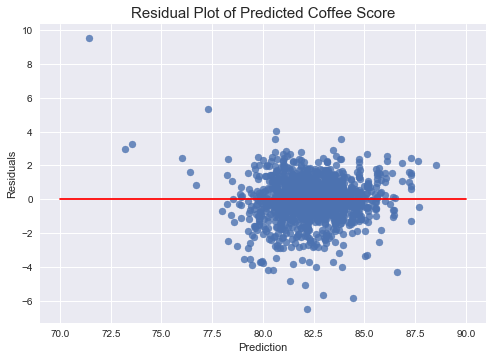

In [61]:
plt.scatter(pred, res, alpha=0.8)
plt.plot(np.linspace(70,90,1000),np.linspace(0,0,1000), 'r')
plt.title("Residual Plot of Predicted Coffee Score", size=15)
plt.xlabel("Prediction")
plt.ylabel("Residuals")

### Create Graphs for Presentation

In [4]:
with open("coffee_master_cleaned.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)

df.head(3)

,ID,Total_Score,Country,Farm,Mill,Company,Altitude,Region,Producer,Number_of_bags,...,Moisture,Defects_cat1,Quakers,Color,Defects_cat2,Bag_weight_fixed,Grading_year,total_weight,Variety_gr,Quakers_gr
0,100409,79.67,Mexico,CONSOLAPA,NaN,ECOMTRADING,1264.0,"COATEPEC, COATEPEC",CECILIA AVILA CAMBEROS,253,...,0.00,0,0,NaN,9,1.0,2012,253.0,Mundo Novo,0
1,10044,80.17,Nicaragua,Los Mesones,Planta procesadora Sebaco,Exportadora Atlantic S.A,1100.0,Jinotega,Sheldom La rue,275,...,0.11,0,0,NaN,2,2.0,2015,550.0,Caturra,0
2,102275,81.67,"Tanzania, United Republic Of",Multiple,DAE Ltd,DAE Ltd Company,1200.0,Mbinga,DAE Ltd,20,...,0.12,0,0,Green,0,60.0,2015,1200.0,Other,0


In [75]:
Sweetness = df.groupby(['Country'])['Sweetness'].mean()
Sweetness.sort_values(ascending=False, inplace=True)
type(Sweetness)

pandas.core.series.Series

In [72]:
Total_Score = df.groupby(['Country'])['Total_Score'].median()
Total_Score.sort_values(ascending=False, inplace=True)
type(Total_Score)

pandas.core.series.Series

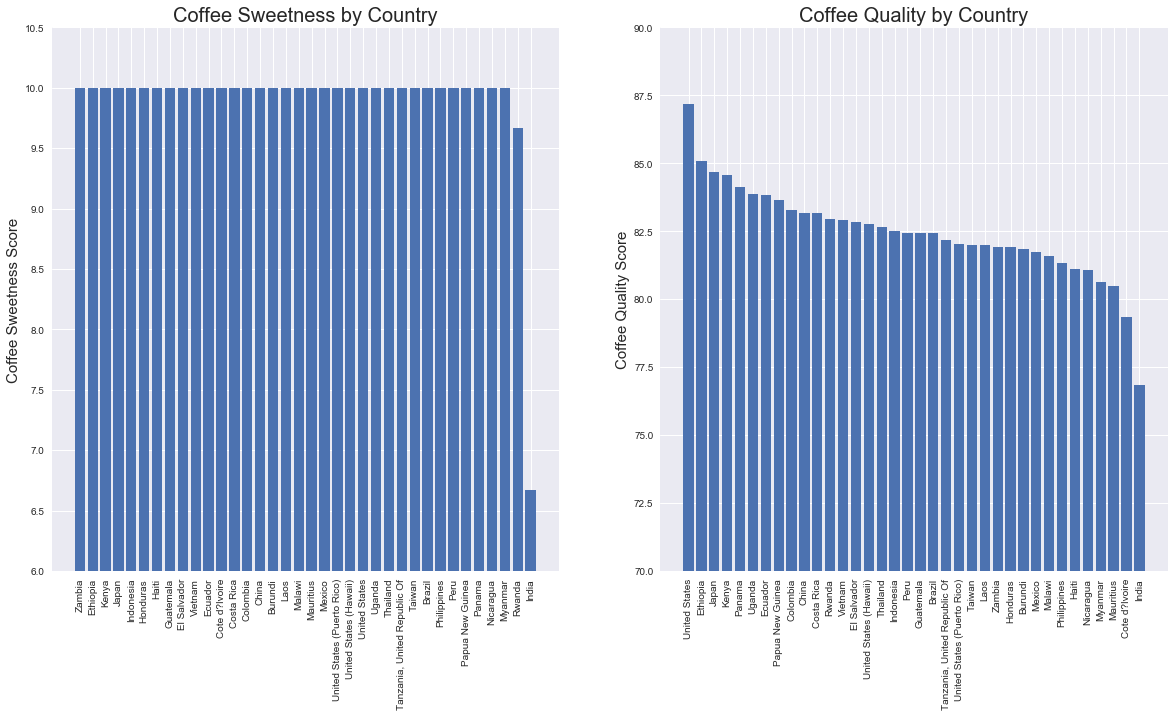

In [73]:
f, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,10))

ax[0].set_title('Coffee Sweetness by Country', size=20)
ax[0].bar(Sweetness.index, Sweetness)
ax[0].set_ylabel('Coffee Sweetness Score', size=15)
ax[0].set_ylim(6,10.5)
for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)

ax[1].set_title('Coffee Quality by Country', size=20)
ax[1].bar(Total_Score.index, Total_Score)
ax[1].set_ylabel('Coffee Quality Score', size=15)
ax[1].set_ylim(70,90)
for tick in ax[1].get_xticklabels():
    tick.set_rotation(90)

Text(0.5,1,'Coffee Sweetness by Country')

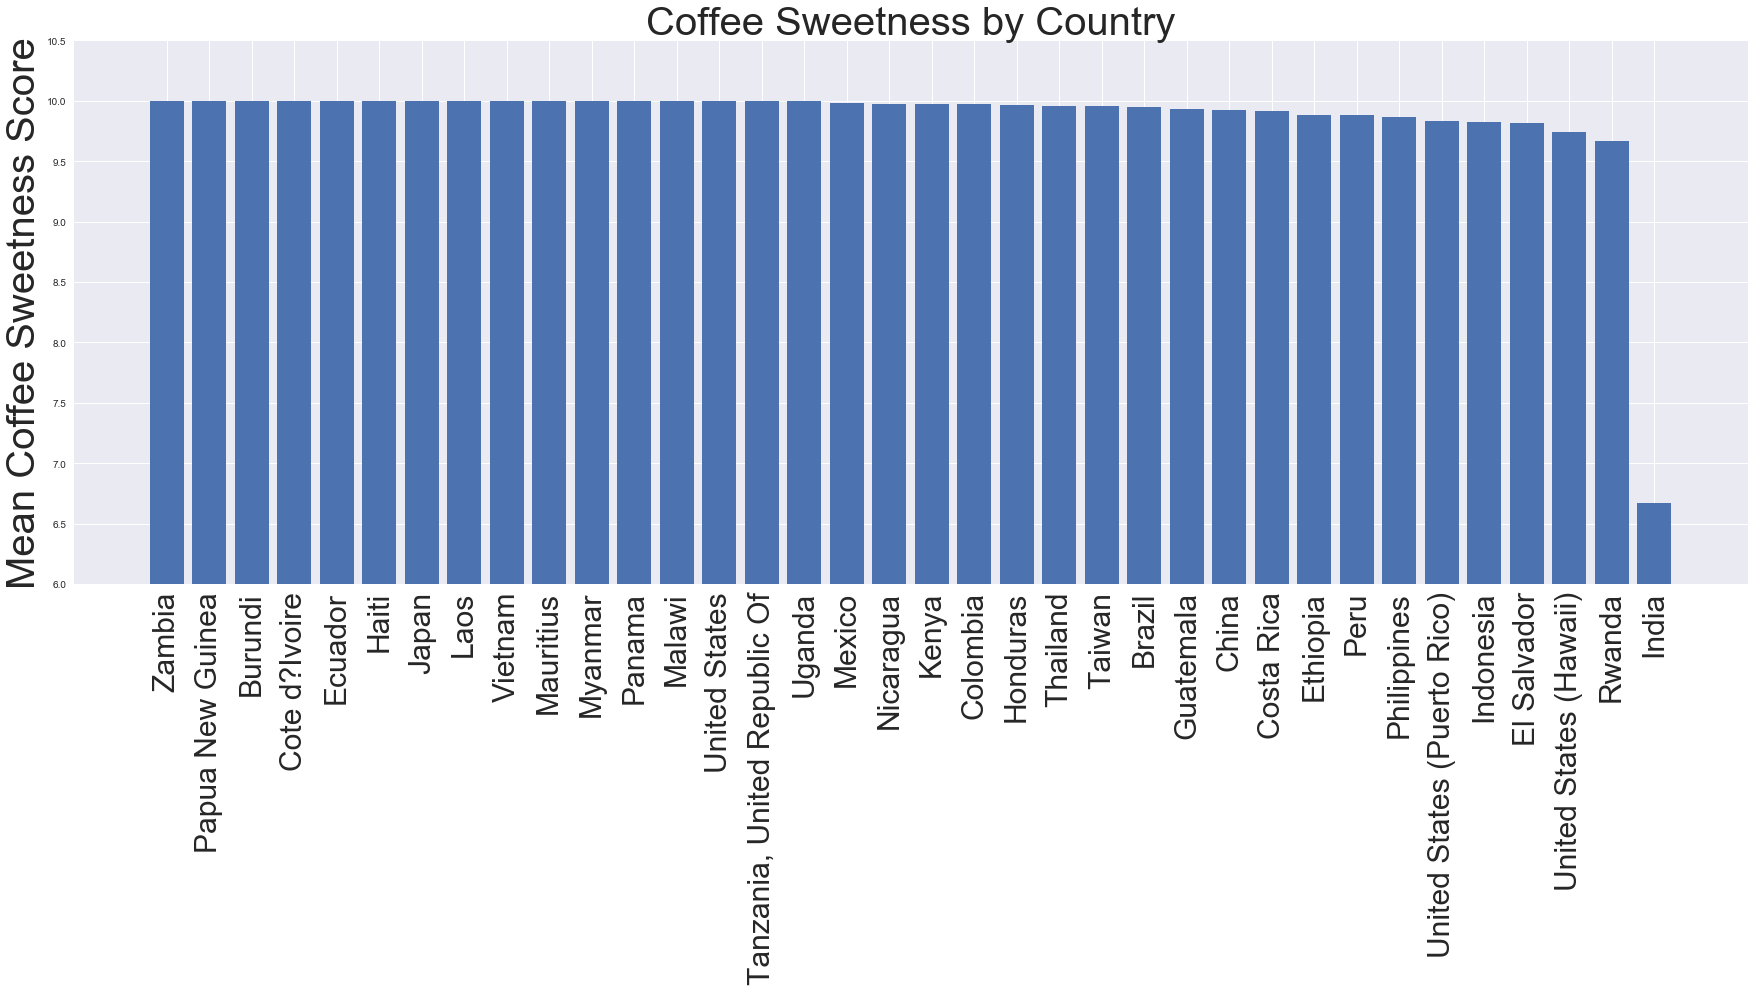

In [127]:
# Individual plots of Sweetness
plt.figure(figsize=(30,10))
plt.bar(Sweetness.index, Sweetness)
plt.ylim(6, 10.5)
plt.ylabel('Mean Coffee Sweetness Score', size=40)
plt.xticks(fontsize=30, rotation=90)
plt.title('Coffee Sweetness by Country', size=40)

Text(0.5,1,'Coffee Quality by Country')

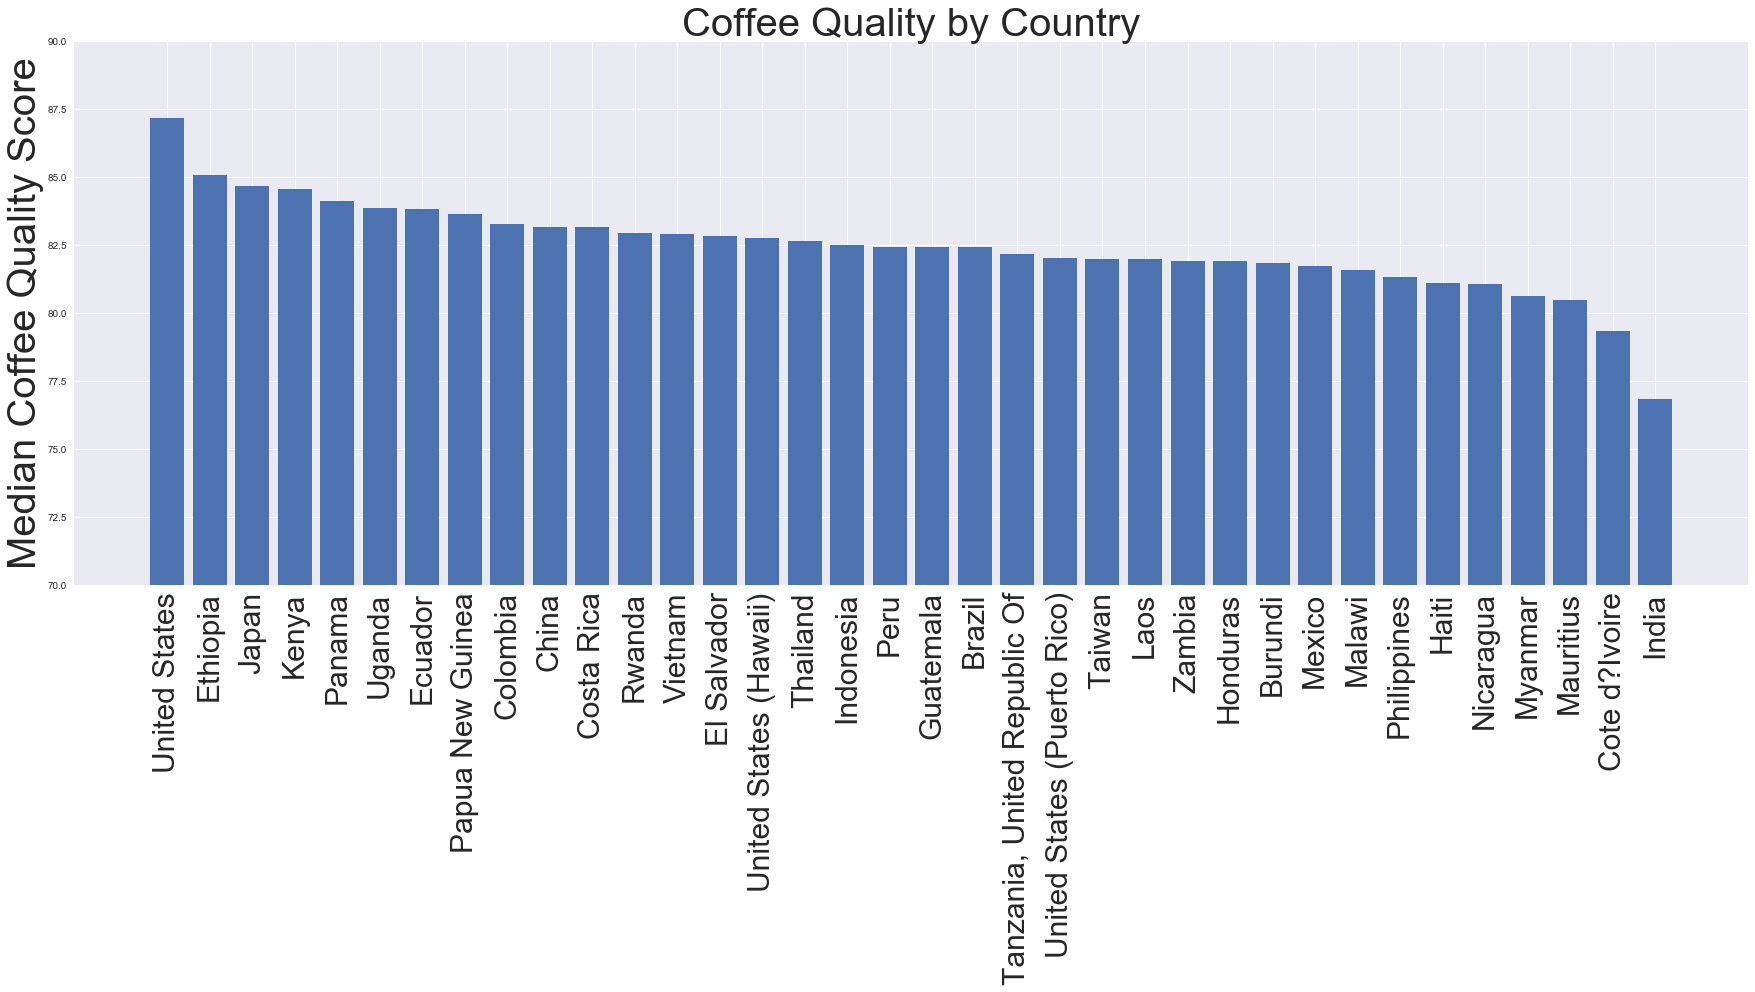

In [128]:
# Individual plots of Quality
plt.figure(figsize=(30,10))
plt.bar(Total_Score.index, Total_Score)
plt.ylim(70, 90)
plt.ylabel('Median Coffee Quality Score', size=40)
plt.xticks(fontsize=30, rotation=90)
plt.title('Coffee Quality by Country', size=40)

### Outlier Analysis

In [90]:
cols=['Country', 'Company', 'Total_Score', 'Altitude', 'Acidity', 'Sweetness',
       'Moisture', 'Defects_cat1', 'Quakers', 'Defects_cat2', 'total_weight', 'Variety', 'Grading_year']

In [95]:
df[cols].sort_values(by=['Sweetness'])[:5]

,Country,Company,Total_Score,Altitude,Acidity,Sweetness,Moisture,Defects_cat1,Quakers,Defects_cat2,total_weight,Variety,Grading_year
814,United States (Hawaii),Kona Pacific Farmers Cooperative,77.58,NaN,7.67,6.00,0.12,1,0,5,226.7960,NaN,2013
747,India,Olam Japan,76.83,NaN,6.67,6.67,0.00,0,7,0,1000.0000,NaN,2017
412,Colombia,ecom cca sa,80.67,1550.00,7.67,6.67,0.00,0,0,1,17500.0000,Caturra,2014
899,Costa Rica,S&D Coffee and Tea,79.17,NaN,8.00,6.67,0.10,5,0,20,2.0000,Catuai,2013
1163,Indonesia,PT. ROYAL PACIFIC INDAH INTERNATIONAL,78.50,NaN,7.58,6.67,0.14,1,5,44,2.0000,Mandheling,2018
1182,Brazil,Ipanema Coffees,82.33,1100.00,8.08,6.67,0.11,0,0,0,20.0000,Bourbon,2014
750,Guatemala,"UNEX (GUATEMALA), S.A",75.58,1310.64,7.58,8.00,0.11,0,0,15,250.0000,Bourbon,2012
719,Honduras,CIGRAH,75.83,1400.00,7.58,8.00,0.11,1,2,8,24150.0000,Caturra,2018
762,United States (Hawaii),Kona Pacific Farmers Cooperative,76.17,NaN,7.58,8.00,0.00,0,0,3,272.1552,NaN,2014
782,Mexico,INDUSTRIALIZADORA DE KAFFEE ANDES S.A. DE C.V.,78.00,850.00,7.00,8.00,0.12,2,0,7,10.0000,Other,2012


In [91]:
df[cols][df['Country']=='India']

,Country,Company,Total_Score,Altitude,Acidity,Sweetness,Moisture,Defects_cat1,Quakers,Defects_cat2,total_weight,Variety,Grading_year
747,India,Olam Japan,76.83,NaN,6.67,6.67,0.0,0,7,0,1000.0,NaN,2017


In [97]:
import numpy as np

def outliers_z_score(ys):
    threshold = 3

    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)

def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))

In [118]:
def outliers(var):
    outz=outliers_z_score(df[var])
    outi=outliers_iqr(df[var])
    print(len(outz[0]))
    print(len(outi[0]))
    print(df[var].mean())
    print(df[var].std())
    if len(outz[0])< len(outi[0]):
        return df[cols].loc[outz]
    else: return df[cols].loc[outi]

var='Defects_cat2'
outliers(var)

29
87
3.43111111111
5.04399424408


,Country,Company,Total_Score,Altitude,Acidity,Sweetness,Moisture,Defects_cat1,Quakers,Defects_cat2,total_weight,Variety,Grading_year
5,Mexico,ESTRATEGIAS CONSTRUCTIVAS CORZU S.A. DE C.V.,80.33,940.0,7.33,10.00,0.11,0,0,21,10.000,Typica,2012
65,Mexico,ECOMTRADING,79.75,1050.0,7.08,10.00,0.10,1,0,22,250.000,Typica,2012
100,Ethiopia,LUSSO COFFEE LAB,84.00,1550.0,7.58,10.00,0.09,4,0,40,3000.000,Other,2014
122,Mexico,NaN,83.00,750.0,7.50,10.00,0.11,0,0,20,15.000,Typica,2012
157,Mexico,CAFÉ PICO DE LORO,79.00,1200.0,7.25,10.00,0.14,7,0,38,120.000,Typica,2012
165,Mexico,NaN,79.33,750.0,7.17,10.00,0.14,0,0,19,50.000,Typica,2012
195,Mexico,NaN,79.33,950.0,7.33,10.00,0.14,0,0,23,30.000,Typica,2012
211,Mexico,NaN,81.75,1250.0,7.67,10.00,0.13,0,0,23,100.000,Mundo Novo,2012
267,China,Yunnan Louis Herbs Modernization Center,81.17,1600.0,7.42,10.00,0.16,0,0,20,2.000,Catimor,2018
290,Myanmar,"Waylead Industrial Co, Ltd.",80.25,914.4,7.33,10.00,0.11,1,0,26,4.000,Other,2015
